In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import load_model, Sequential, Model
from sklearn.metrics import confusion_matrix
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split

In [ ]:
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

# Просто функции
## (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧

In [ ]:
def to_Bin(number): # лютый хардкод (╯°□°）╯︵ ┻━┻, ужас, потом переделать 
    number = str(number)
    binNumber = list('0000000000000')

    dictOfRule = {
        '0' : [0, 0, 0],
        '1' : [1, 0, 0],
        '2' : [0, 1, 0],
        '3' : [1, 1, 0],
        '4' : [0, 0, 1],
        '5' : [1, 0, 1],
        '6' : [0, 1, 1],
        '7' : [1, 1, 1]
    }
    while(len(number)<4):
        number = '0' + number

    binNumber[0] = dictOfRule[number[2]][0]
    binNumber[1] = dictOfRule[number[0]][0]
    binNumber[2] = dictOfRule[number[2]][1]
    binNumber[3] = dictOfRule[number[0]][1]
    binNumber[4] = dictOfRule[number[2]][2]
    binNumber[5] = dictOfRule[number[0]][2]
    binNumber[6] = 0
    binNumber[7] = dictOfRule[number[1]][0]
    binNumber[8] = dictOfRule[number[3]][0]
    binNumber[9] = dictOfRule[number[1]][1]
    binNumber[10] = dictOfRule[number[3]][1]
    binNumber[11] = dictOfRule[number[1]][2]
    binNumber[12] = dictOfRule[number[3]][2]

    bin = str()
    for i in binNumber:
        bin = bin + str(i)
    bin = list(bin)
    bin.insert(0,'1')
    bin.append('1')
    
    return bin

def to_Dex(input):

    '''Функция выполняет декодирование двоичного сигнала сквока и возвращает десятичное число\n

    Parameters
    ----------
        input : dtype = int, двоичное число\n'''

    bin = str()
    input = str(input)
    
    input = list(input)
    input.pop(0)
    input.pop(-1)
    input = ''.join(input)
        
    n1 = int(input[1])*1 + int(input[3])*2 + int(input[5])*4
    n2 = int(input[7])*1 + int(input[9])*2 + int(input[11])*4
    n3 = int(input[0])*1 + int(input[2])*2 + int(input[4])*4
    n4 = int(input[8])*1 + int(input[10])*2 + int(input[12])*4
    
    bin = int(str(n1) + str(n2) + str(n3) + str(n4))

    return bin

def plotPred(listOfInd, dataTest, dataPred):
    
    if (type(listOfInd)!=type(list())):
        listOfInd = list(listOfInd)
    lenght = len(listOfInd)
    n1 = 0
    n2 = 0
    
    fig = plt.figure(figsize=(5.33*lenght,8))    
    
    for i in range(1,lenght*2+1):
        exec('ax'+str(i)+' = fig.add_subplot(2,'+str(lenght)+','+str(i)+')')
    
    for i in range(1,lenght+1):
        exec('ax'+str(i)+'.set_yscale(\'log\')')    
    
    for i in range(1,lenght*2+1):
        if (i<=lenght):
            exec('ax'+str(i)+'.bar(range(dataPred[0].shape[0]),dataPred['+str(listOfInd[n1])+'], width=0.3, edgecolor="white", linewidth=1)')
            exec('ax'+str(i)+'.set_title(\'Предсказанные импульсы\')')
            n1 += 1
        else:
            exec('ax'+str(i)+'.plot(dataTest['+str(listOfInd[n2])+'])')
            exec('ax'+str(i)+'.set_title(\'Реальный сигнал\')')
            n2 += 1
            
def single_predict(n, data, sense):
    
    
    X = np.array([data.iloc[n,1:86]])
    
    xt = (X.T[:,:] - X.T[:,:].mean())/ X.T[:,:].std()
    yt = np.array(to_Bin(int(data.iloc[n,0]))).astype(float)
    
    xt = xt.reshape(1,-1)
    
    bin_pred = nn.predict(xt,verbose=0)

    
    lim = eval('1.0e-'+str(sense))
    bin_pred[np.where(bin_pred<lim)] = 0 
    bin_pred[np.where(bin_pred>=lim)] = 1

    rs_predictions = bin_pred.reshape(-1,1)
    rs_y_test = yt.reshape(-1,1)

    plotPred([0], xt, bin_pred)
    
    bin_pred = bin_pred.astype(int).astype(str).reshape(-1)    
    bin_pred = ''.join(bin_pred)
    print("Реальный сквок: {0}\nПредсказанный сквок: {1}".format(int(data.iloc[n,0]),to_Dex(bin_pred)))    
    
    cm = confusion_matrix(rs_predictions, rs_y_test)

    figure = plt.figure(figsize=(5, 4))
    ax = sn.heatmap(cm, annot=True,fmt='g',cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def single_predictYON(n, data):
    
    n_classes = 2 # кол-во используемых классов 
    
    X = np.array([data.iloc[n,1:]])
    Y = np.array([data.iloc[n,0]]).astype(int)
    data.iloc[n,1:].plot()

    xt = (X.T[:,:] - X.T[:,:].mean())/ X.T[:,:].std()
    yt = np_utils.to_categorical(Y, n_classes) 

    xt = xt.reshape(1,-1)

    predictions = nnYON.predict(xt,verbose=0) 

    pred = np.argmax(predictions, axis = 1)
    target_test = np.argmax(yt, axis = 1)

    print("Есть ли тут сигнал сквока\n0 - нет, 1 - есть\n"
        "Реальное значение: {0}\n"
        "Значение предикта: {1}\n"
        
        .format(target_test[0],pred[0]))


In [ ]:
# ------------------------------------------------------------------------------------------------ #

# Танцы с *датафреймом* 
## (╬▔皿▔)╯

In [ ]:
dft = pd.read_csv('../data/out/dfEdited.csv')
dataAC = pd.read_csv('../data/detection/DataSet_AC_sig_pom_title.csv')
dft = dft.drop('Unnamed: 0', axis=1)

In [ ]:
dft.head(3)

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample76,sample77,sample78,sample79,sample80,sample81,sample82,sample83,sample84,sample85
0,0,537.90,1647.9,396.92,97.252,81.320,86.279,941.60,13.892,64.661,...,226.210,74.673,158.620,37.656,20.248,81.615,297.470,1581.6,672.33,143.850
1,0,212.90,1657.5,1134.00,91.082,151.400,55.902,434.19,41.485,44.385,...,83.217,67.676,46.098,91.482,40.012,31.064,81.615,1394.2,1494.40,53.085
2,0,105.22,1385.6,1053.30,125.210,18.248,51.856,265.71,48.104,75.027,...,51.624,90.918,45.044,63.253,69.116,63.159,76.164,1134.3,1245.20,90.609


In [ ]:
valuesList = list()
for i in dft['label']:
    valuesList.append(to_Bin(i))
    
labels = list()
for i in range(15):
    labels.append('x'+str(i))

In [ ]:
dft[labels] = valuesList
dft

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0,537.900,1647.90,396.92,97.252,81.320,86.279,941.600,13.892,64.661,...,0,0,0,0,0,0,0,0,0,1
1,0,212.900,1657.50,1134.00,91.082,151.400,55.902,434.190,41.485,44.385,...,0,0,0,0,0,0,0,0,0,1
2,0,105.220,1385.60,1053.30,125.210,18.248,51.856,265.710,48.104,75.027,...,0,0,0,0,0,0,0,0,0,1
3,0,123.490,1548.10,1051.50,122.070,44.944,87.235,397.850,51.865,36.674,...,0,0,0,0,0,0,0,0,0,1
4,0,238.450,1584.00,833.78,108.240,33.838,128.320,528.780,107.840,86.023,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655995,7624,105.690,424.29,227.78,71.169,8.544,29.069,71.021,43.186,23.854,...,0,1,0,0,0,1,0,1,1,1
2655996,7624,63.561,346.14,405.28,61.555,13.342,51.923,90.139,60.141,30.150,...,0,1,0,0,0,1,0,1,1,1
2655997,7624,33.615,379.60,305.98,57.940,90.139,40.706,110.570,62.394,35.468,...,0,1,0,0,0,1,0,1,1,1
2655998,7624,71.610,409.27,355.83,32.202,44.147,27.000,103.310,52.240,63.789,...,0,1,0,0,0,1,0,1,1,1


In [ ]:
# --------------------------------------------------------------------- #

# Классификатор **"Свой - Чужой"**

## 〜(￣▽￣〜) . . . (〜￣▽￣)〜

In [ ]:
dataAC.head(3)

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample76,sample77,sample78,sample79,sample80,sample81,sample82,sample83,sample84,sample85
0,0,-0.45757,-0.58749,1.27100,0.13010,-1.00130,-0.22555,1.51220,0.65994,-1.0259,...,-0.345290,1.956800,0.011627,-0.60047,-0.44952,1.64720,0.30326,-0.71368,-0.55759,1.64480
1,0,-0.60022,1.25520,0.11619,-1.01340,-0.23887,1.49600,0.64517,-1.03790,-1.0318,...,1.939900,-0.002086,-0.613170,-0.46248,1.63090,0.28907,-0.72620,-0.57037,1.62840,0.69345
2,0,1.25440,0.12221,-1.00060,-0.23073,1.49380,0.64802,-1.02500,-1.01890,-1.1094,...,0.004642,-0.602790,-0.452990,1.62780,0.29406,-0.71513,-0.56023,1.62540,0.69601,-1.16070


In [ ]:
X_data = dataAC.iloc[:,1:86].values
Y_data = dataAC.iloc[:,0].values

X_data = X_data.astype('float32')
Y_data = Y_data.astype('float32')

print(X_data.shape, Y_data.shape)

(88000, 85) (88000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, random_state=42)

In [ ]:

# нормализация 
X_train_norm = (X_train.T[:,:] - X_train.T[:,:].mean())/ X_train.T[:,:].std()
X_test_norm = (X_test.T[:,:] - X_test.T[:,:].mean())/ X_test.T[:,:].std()

X_train_norm = X_train_norm.T
X_test_norm = X_test_norm.T

# бинарное кодирование предикторов
n_classes = 2
y_train_bin = np_utils.to_categorical(y_train, n_classes) 
y_test_bin = np_utils.to_categorical(y_test, n_classes) 

In [ ]:
try:
    del(nnYON, modelYON)
    print("deleted")
except:
    None

modelYON = Sequential()
modelYON.add(Dense(85, activation='softsign', input_dim=85)) # 256
modelYON.add(Dropout(0.5))
modelYON.add(Dense(2, activation='softmax'))
modelYON.compile(loss="binary_crossentropy", # categorical_crossentropy binary_crossentropy
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

modelYON.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                7310      
_________________________________________________________________
dropout (Dropout)            (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 172       
Total params: 7,482
Trainable params: 7,482
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
528/528 [==============================] - 3s 2ms/step - loss: 0.1880 - accuracy: 0.9268 - val_loss: 0.0247 - val_accuracy: 0.9987
Epoch 2/3
528/528 [==============================] - 1s 1ms/step - loss: 0.0154 - accuracy: 0.9986 - val_loss: 0.0054 - val_accuracy: 0.9997
Epoch 3/3
528/528 [==============================] - 1s 1ms/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9997


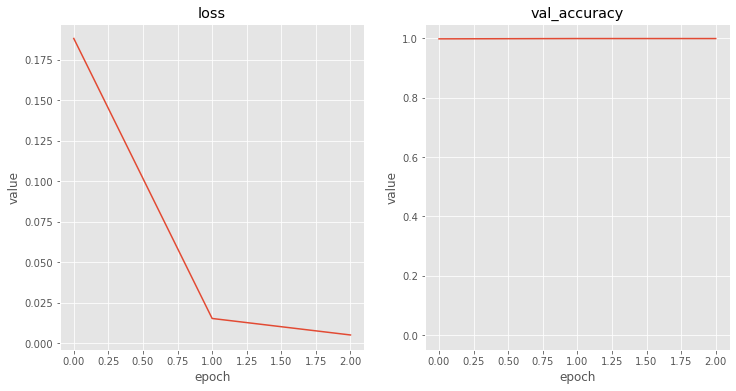

In [ ]:
np.random.seed(1337) 
nnYON = modelYON.fit(X_train_norm, y_train_bin, batch_size=100, epochs = 3, verbose = 1, validation_split = 0.2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1.plot(nnYON.history['loss'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('value')

ax2.plot(nnYON.history['val_accuracy'])
ax2.set_title('val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('value')

plt.show()

In [ ]:
predictions = modelYON.predict(X_test_norm,verbose=1) 

pred = np.argmax(predictions, axis = 1)
target_test = np.argmax(y_test_bin, axis = 1)


688/688 [==============================] - 0s 398us/step


Кол-во значений на предикте: 22000


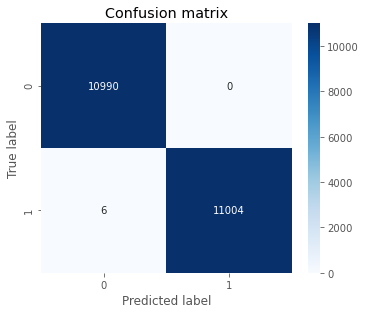

In [ ]:
cm = confusion_matrix(pred, target_test)
print("Кол-во значений на предикте: {}".format(target_test.shape[0]))
figure = plt.figure(figsize=(5, 4))
ax = sn.heatmap(cm, annot=True,fmt='g',cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
del(X_data, Y_data, X_train, X_test, y_train, y_test, X_train_norm, X_test_norm, y_train_bin, y_test_bin, predictions, pred, target_test)

In [ ]:
# nnYON.save('.\\saved_model\\nnYON')

In [ ]:
# --------------------------------------------------------------------------- #

# ***Нейронка***
## (。_ 。)

In [ ]:
n_classes = 1328 # кол-во используемых классов (max=1328)

In [ ]:
X_data = dft.iloc[:n_classes*2000,1:86].values
Y_data = dft.iloc[:n_classes*2000,86:].values

In [ ]:
X_data = X_data.astype('float32')
Y_data = Y_data.astype('float32')

In [ ]:
print(X_data.shape, Y_data.shape)

(2656000, 85) (2656000, 15)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, random_state=42)

In [ ]:
X_train_norm = (X_train.T[:,:] - X_train.T[:,:].mean())/ X_train.T[:,:].std()
X_test_norm = (X_test.T[:,:] - X_test.T[:,:].mean())/ X_test.T[:,:].std()

X_train_norm = X_train_norm.T
X_test_norm = X_test_norm.T

In [ ]:
try:
    del(nn, model)
    print("deleted")
except:
    None

model = Sequential()
model.add(Dense(85, activation='softsign', input_dim=85)) # 256
model.add(Dropout(0.5))
model.add(Dense(250, activation='softsign'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))
model.compile(loss="binary_crossentropy", # categorical_crossentropy binary_crossentropy
              optimizer=Adam(learning_rate=0.0008),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 85)                7310      
_________________________________________________________________
dropout_13 (Dropout)         (None, 85)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 250)               21500     
_________________________________________________________________
dropout_14 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 15)                3765      
Total params: 32,575
Trainable params: 32,575
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
3188/3188 [==============================] - 17s 5ms/step - loss: 0.0473 - accuracy: 0.1494 - val_loss: 1.7445e-04 - val_accuracy: 0.1980
Epoch 2/10
3188/3188 [==============================] - 15s 5ms/step - loss: 0.0098 - accuracy: 0.1229 - val_loss: 3.4761e-05 - val_accuracy: 0.3552
Epoch 3/10
3188/3188 [==============================] - 16s 5ms/step - loss: 0.0056 - accuracy: 0.1422 - val_loss: 2.4438e-05 - val_accuracy: 0.5164
Epoch 4/10
3188/3188 [==============================] - 18s 6ms/step - loss: 0.0043 - accuracy: 0.1887 - val_loss: 3.1532e-05 - val_accuracy: 0.7527
Epoch 5/10
3188/3188 [==============================] - 15s 5ms/step - loss: 0.0037 - accuracy: 0.2427 - val_loss: 1.9721e-05 - val_accuracy: 0.8210
Epoch 6/10
3188/3188 [==============================] - 16s 5ms/step - loss: 0.0034 - accuracy: 0.2882 - val_loss: 2.6085e-05 - val_accuracy: 0.7270
Epoch 7/10
3188/3188 [==============================] - 16s 5ms/step - loss: 0.0032 - accuracy: 0.2944 - v

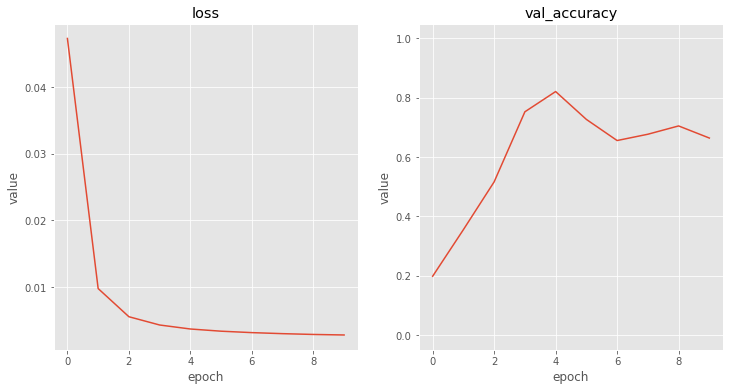

In [ ]:
np.random.seed(1337) 
nn = model.fit(X_train_norm, y_train, batch_size=500, epochs = 10, verbose = 1, validation_split = 0.2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1.plot(nn.history['loss'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('value')

ax2.plot(nn.history['val_accuracy'])
ax2.set_title('val_accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylim(-0.05,1.05)
ax2.set_ylabel('value')

plt.show()

In [ ]:
predictions = model.predict(X_test_norm,verbose=1) 

20750/20750 [==============================] - 15s 710us/step


In [ ]:
backup = predictions.copy()

In [ ]:
predictions = backup.copy()

In [ ]:
# plotPred([0, 3000, 6000, 9000, 12000], X_test_norm, predictions)

In [ ]:
lim = 1.0e-14
predictions[np.where(predictions<lim)] = 0 
predictions[np.where(predictions>=lim)] = 1
predictions[0]

array([1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [ ]:
# plotPred([9000,12000,15000], X_test_norm, predictions)

In [ ]:
rs_predictions = predictions.reshape(-1,1)
rs_y_test = y_test.reshape(-1,1)

Кол-во значений на предикте: 9960000
Точность модели: 99.998926%


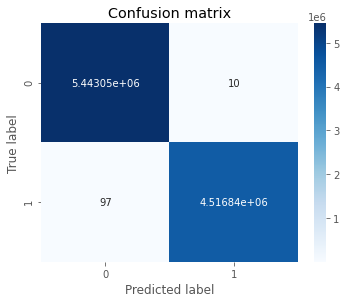

In [ ]:
cm = confusion_matrix(rs_predictions, rs_y_test)
print("Кол-во значений на предикте: {0}\n"
    "Точность модели: {1:0.6%}"
    .format(rs_y_test.shape[0],
    1 - (cm.item(1)+cm.item(2))/(cm.item(0)+cm.item(3))))
figure = plt.figure(figsize=(5, 4))
ax = sn.heatmap(cm, annot=True,fmt='g',cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
# del(X_data, Y_data, X_train, X_test, y_train, y_test, X_train_norm, X_test_norm, predictions, lim, rs_predictions, rs_y_test)

In [ ]:
# nn.save('.\\saved_model\\nn')

In [ ]:
# --------------------------------------------------------------------------- #

# ***Тесты***
## (°ー°〃)

> тест классификатора **"Свой - Чужой"**

In [ ]:
data7dB = pd.read_csv('../data/detection/DataSet_Det7dB.csv')
data7dB.head(3)

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample76,sample77,sample78,sample79,sample80,sample81,sample82,sample83,sample84,sample85
0,0,1.63140,-0.23386,-1.01240,-0.98238,-0.91513,-0.48375,1.26820,0.59675,1.11280,...,-1.4546,-0.61705,0.13272,1.59060,0.5119,0.91648,-0.80255,-1.0909,-0.67221,1.30030
1,0,0.52446,-1.11860,-0.72705,1.00580,0.57021,-0.78624,-0.86641,1.35130,0.37971,...,1.3879,0.69198,-1.09930,-0.53294,1.3618,0.65013,-1.37160,-0.5493,1.57250,0.23054
2,0,1.00850,1.03030,0.57576,-0.97689,-0.84913,1.15220,0.68773,-1.19360,-0.75509,...,-1.1038,-0.90482,-1.04870,-0.78170,1.0791,1.07380,1.11080,0.4517,-1.13850,-1.11160


In [ ]:
nnYON = load_model('../data/saved_model/nnYON')
nnYON.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 85)                7310      
_________________________________________________________________
dropout (Dropout)            (None, 85)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 172       
Total params: 7,482
Trainable params: 7,482
Non-trainable params: 0
_________________________________________________________________


Есть ли тут сигнал сквока
0 - нет, 1 - есть
Реальное значение: 1
Значение предикта: 1



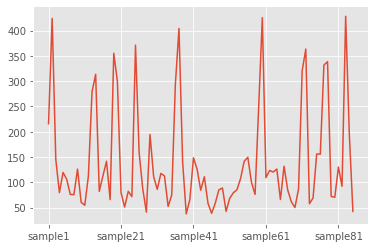

In [ ]:
single_predictYON(3888, data7dB)

> тест ***нейронки***

In [ ]:
data_x1 = pd.read_csv('../data/out/Squawk_x1.csv')
data_x1.head(3)

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample76,sample77,sample78,sample79,sample80,sample81,sample82,sample83,sample84,sample85
0,0.0,1010.00,1660.2,272.16,53.413,25.495,21.954,13.892,64.661,19.026,...,74.673,158.62,37.656,56.036,44.777,55.073,179.81,1510.9,987.69,40.46
1,4.0,568.92,1836.9,632.66,53.413,25.495,21.954,13.892,64.661,19.026,...,1049.400,1505.50,145.990,56.036,44.777,55.073,495.36,1768.1,720.47,40.46
2,400.0,733.03,1641.2,389.38,53.413,25.495,21.954,13.892,64.661,19.026,...,74.673,158.62,37.656,56.036,44.777,55.073,256.09,1673.3,986.88,40.46


In [ ]:
dft = pd.read_csv('../data/out/dfEdited.csv')
dft = dft.drop('Unnamed: 0', axis=1)
dft.head(3)

,label,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,...,sample76,sample77,sample78,sample79,sample80,sample81,sample82,sample83,sample84,sample85
0,0,537.90,1647.9,396.92,97.252,81.320,86.279,941.60,13.892,64.661,...,226.210,74.673,158.620,37.656,20.248,81.615,297.470,1581.6,672.33,143.850
1,0,212.90,1657.5,1134.00,91.082,151.400,55.902,434.19,41.485,44.385,...,83.217,67.676,46.098,91.482,40.012,31.064,81.615,1394.2,1494.40,53.085
2,0,105.22,1385.6,1053.30,125.210,18.248,51.856,265.71,48.104,75.027,...,51.624,90.918,45.044,63.253,69.116,63.159,76.164,1134.3,1245.20,90.609


In [ ]:
nn = load_model('../data/saved_model/nn')
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 85)                7310      
_________________________________________________________________
dropout_1 (Dropout)          (None, 85)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               21500     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                3765      
Total params: 32,575
Trainable params: 32,575
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainSq = list(dft['label'].unique())
allSq = list(data_x1['label'].astype(int).unique())
noneUse = allSq.copy()
for i in range(len(trainSq)):
    for j in range(len(trainSq)):
        if i == j:
            noneUse.pop(i)
            
print("Кол-во сквоковов используемых в обучении: {0}\n"
    "Кол-во сквоков НЕ используемых в обучении: {1}"
      .format(4096-len(noneUse), len(noneUse)))

Кол-во сквоковов используемых в обучении: 1328
Кол-во сквоков НЕ используемых в обучении: 2768


Реальный сквок: 1652
Предсказанный сквок: 1652


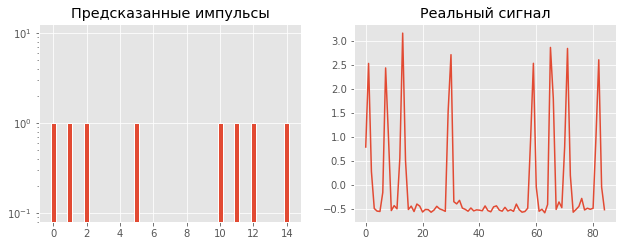

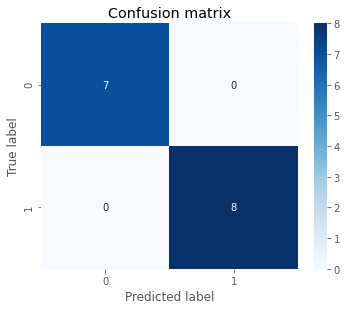

In [ ]:
n = 606           # выбор от 0 до 2767 (ТОЛЬКО не исп. сквоки)

single_predict(data_x1.loc[data_x1['label']==noneUse[n]].index[0] #data_x1.loc[data_x1['label']==noneUse[n]].index.asof(noneUse[n]
               , data_x1, sense=18)  

# single_predict(0, data_x1) # выбор от 0 до 4095 (все исп. сквоки)